# import thư viện

In [1]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.layers import GlobalAveragePooling2D, MaxPooling2D, Dropout, Flatten, Dense, Input, BatchNormalization
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [2]:
LR = 1e-4
Epochs = 50
Bs = 64

# CRAW Dữ liệu

In [3]:
Dir1= '/kaggle/input/coco-car-damage-detection-dataset/img'
Dir1_1 = '/kaggle/input/my-dataset/my_dataset/00-damage'
Dir1_2 = '/kaggle/input/my-dataset/my_dataset/00-damage1'
Dir1_3 = '/kaggle/input/car-parts-and-car-damages/Car damages dataset/File1/img'
Dir1_4 = '/kaggle/input/car-parts-and-car-damages/Car parts dataset/File1'
path1 = [Dir1, Dir1_1, Dir1_2, Dir1_3]

data1=[]
labels1=[]

# lấy dữ liệu xe bị hỏng
for d in path1:
    for img in os.listdir(d):
        img_path = os.path.join(d, img)
    #     check = Image.open(img_path)
    #     print(check.size)
        image = load_img(img_path, target_size=(224, 224)) #size ban đầu là (1024,1024)

        image = img_to_array(image)
        image = preprocess_input(image)

        data1.append(image)
        labels1.append(0)
        if len(data1) == 2000: break
print(len(data1))

2000


In [4]:
Dir2 = '/kaggle/input/my-dataset/my_dataset/01-whole'
Dir2_2 = '/kaggle/input/my-dataset/my_dataset/01-whole1'
Dir2_3 = '/kaggle/input/stanford-cars-dataset/cars_train/cars_train'
path2 = [Dir2, Dir2_2, Dir2_3]
data2 = []
labels2 = []
#lấy dữ liệu xe không bị hỏng
for d in path2:
    for img in os.listdir(d):
        img_path = os.path.join(d, img)
    #     check = Image.open(img_path)
    #     print(check.size)

        image = load_img(img_path, target_size=(224, 224)) #size ban đầu là (500,333)

        image = img_to_array(image)
        image = preprocess_input(image)

        data2.append(image)
        labels2.append(1)
        if len(data2) == 2000: break
print(len(data2))

2000


In [5]:
data, labels = [], []
data = data1 + data2
labels = labels1 + labels2
print(len(data))

4000


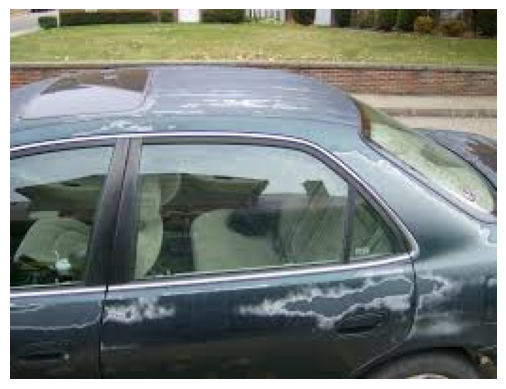

In [6]:
import cv2
from matplotlib import pyplot as plt

im = cv2.imread('/kaggle/input/my-dataset/my_dataset/00-damage/0002.JPEG')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Tắt trục tọa độ
plt.show()

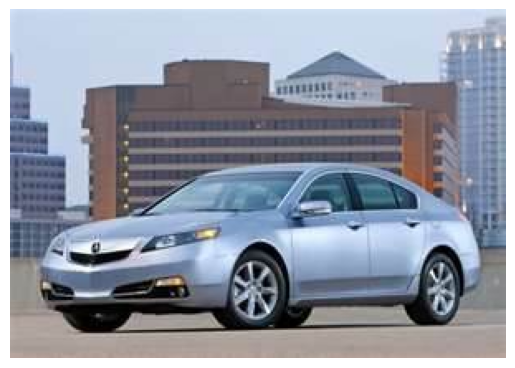

In [7]:
import cv2
from matplotlib import pyplot as plt

im = cv2.imread('/kaggle/input/my-dataset/my_dataset/01-whole/0005.jpg')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Tắt trục tọa độ
plt.show()

In [ ]:
# Dir_train= '/kaggle/input/dataset/Damaged Car/data1a/training'
# Dir_val='/kaggle/input/dataset/Damaged Car/data1a/validation'
# categories = ['00-damage', '01-whole']

# data=[]
# labels=[]

# damage = 0
# whole = 0
# for category in categories:
#   path = os.path.join(Dir_train, category)
#   for img in os.listdir(path):
#     img_path = os.path.join(path, img)
#     image = load_img(img_path, target_size=(224, 224))
#     image = img_to_array(image)
#     image = preprocess_input(image)

#     data.append(image)
#     labels.append(category)
#     if category == '00-damage':
#       damage += 1
#     else: whole += 1

# for category in categories:
#   path = os.path.join(Dir_val, category)
#   for img in os.listdir(path):
#     img_path = os.path.join(path, img)
#     image = load_img(img_path, target_size=(224, 224))
#     image = img_to_array(image)
#     image = preprocess_input(image)

#     data.append(image)
#     labels.append(category)
#     if category == '00-damage':
#       damage += 1
#     else: whole += 1

In [ ]:
# print("Tổng số ảnh: ",len(data))
# print("số ảnh hư hỏng:",damage)
# print("số ảnh nguyên vẹn:",whole)

In [ ]:
data.shape

# Xử lý dữ liệu và gán nhãn

In [8]:
#perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
data = np.array(data, dtype='float32')
labels = np.array(labels)

(trainX, testX, trainy, testy) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=24) #stratify: phân chia theo tầng

In [9]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [10]:
d = 0
for i in testy:
    if i[0] == 1: d+=1
print('damage: ', d)
print('not damage: ', len(testy)-d)

damage:  400
not damage:  400


xe bị hỏng [1,0]
xe ko bị hỏng [0, 1]

In [11]:
print('Số lượng train:', len(trainX))
print('Số lượng test:', len(testX))

Số lượng train: 3200
Số lượng test: 800


# Augmentation

In [12]:
#construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
#     zoom_range=0.15,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Thêm lật dọc
    brightness_range=[0.5, 1.5]  # Thêm biến đổi màu
#     fill_mode='nearest'
)


# Build Model

In [15]:
#Load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 [==============================] - 1s 0us/step


In [16]:
x = baseModel.output
print(x.shape)

(None, 7, 7, 1280)


In [17]:
#construct the head of the model that will be placed on top of the base model

x = baseModel.output
x = MaxPooling2D(pool_size=(7, 7))(x)
x = Flatten(name="flatten")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.25)(x)
output = Dense(2, activation="softmax")(x)

#Place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=output)

for layer in baseModel.layers:
	layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

Tập validate đơn giản hơn tập training
=> do tập training có augmentation (tăng cường dữ liệu thêm khó khăn hơn)

# compile model

In [ ]:
# from keras import models
# model = models.load_model('/kaggle/input/model-check/MobileNet_car_damage_check.model')

In [19]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy']
              )
# my_callback = [ReduceLROnPlateau(min_lr=0.0000001),
#                ModelCheckpoint('/mobileNet_epoch_val/mobileNet2_{epoch:}_{val_accuracy:}.hdf5', monitor='val_accuracy',save_best_only=True)]


In [ ]:
history = model.fit(
	aug.flow(trainX, trainy, batch_size=Bs),
	steps_per_epoch=len(trainX) // Bs,
	validation_data=(testX, testy),
	validation_steps=len(testX) // Bs,
	epochs=50,
  )

In [ ]:
model.save('MobileNet_car_damage_FINAL1.model', save_format = 'h5')

# Predict

In [21]:
from keras import models
model = models.load_model('/kaggle/input/my-model-final/MobileNet_car_damage_FINAL.model')

In [14]:
# make predictions on the testing set
predict= model.predict(testX, batch_size=Bs)
pred = np.argmax(predict, axis = 1)
target_names = list(map(str, lb.classes_))
print(classification_report(testy.argmax(axis=1), pred, target_names = target_names))

13/13 [==============================] - 12s 851ms/step
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       400
           1       0.88      0.90      0.89       400

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800



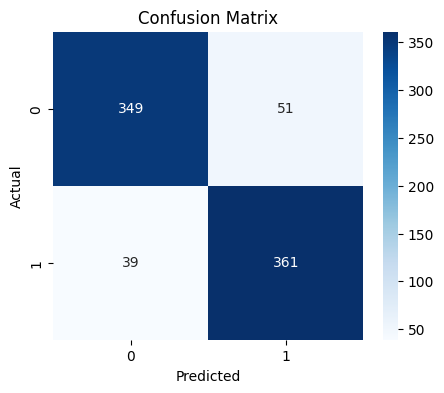

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Tạo confusion matrix
conf_matrix = confusion_matrix(testy.argmax(axis=1), pred)

# Hiển thị bảng confusion matrix dưới dạng heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', 
            xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [23]:
model.evaluate(testX, testy)

25/25 [==============================] - 12s 428ms/step - loss: 0.3010 - accuracy: 0.8875


[0.30104005336761475, 0.887499988079071]

In [ ]:
N = 50
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('loss/accuaracy')
plt.legend(loc='upper left')
plt.savefig('mobileNet.png')


# Predict a picture

In [26]:
from keras import models
MobileNet = models.load_model('/kaggle/input/my-model-final/MobileNet_car_damage_FINAL.model')

In [24]:
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import matplotlib.pyplot as plt

(1, 224, 224, 3)
1/1 [==============================] - 1s 693ms/step
car is damaged: 0.99990404, car is not damaged: 9.59991e-05
the car is damaged


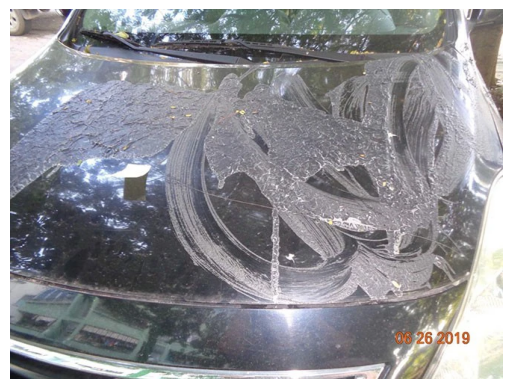

In [27]:
img_path = '/kaggle/input/data-test22/anh_testtt.png'
img = image.load_img(img_path, target_size=(224, 224))
img_array= image.img_to_array(img)
img_batch = preprocess_input(img_array)
img_batch = np.expand_dims(img_batch, axis = 0)
print(img_batch.shape)

im = cv2.imread(img_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(im)

pred = MobileNet.predict(img_batch)
print("car is damaged: " + str(pred[0][0])+ ", car is not damaged: " + str(pred[0][1]))
if(pred[0][0] < pred[0][1]):
  print('the car is not damaged')
else:
  print('the car is damaged')

1/1 [==============================] - 0s 45ms/step
[[0.99120367 0.00879631]]
1/1 [==============================] - 0s 41ms/step
[[1.1016470e-05 9.9998903e-01]]
1/1 [==============================] - 0s 44ms/step
[[0.9985415  0.00145851]]
1/1 [==============================] - 0s 44ms/step
[[5.4346427e-04 9.9945658e-01]]
1/1 [==============================] - 0s 39ms/step
[[3.711502e-06 9.999963e-01]]
1/1 [==============================] - 0s 37ms/step
[[0.00148905 0.9985109 ]]
1/1 [==============================] - 0s 37ms/step
[[9.9932146e-01 6.7851075e-04]]
1/1 [==============================] - 0s 37ms/step
[[0.9933615  0.00663856]]
1/1 [==============================] - 0s 40ms/step
[[0.9985934  0.00140655]]
1/1 [==============================] - 0s 46ms/step
[[2.4848655e-04 9.9975151e-01]]


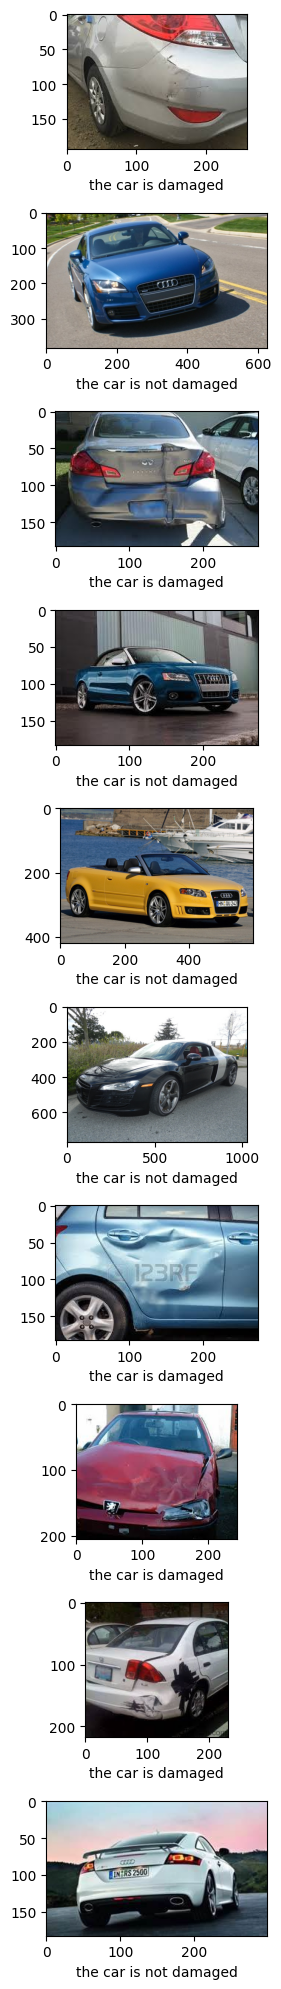

In [28]:
path_test = '/kaggle/input/my-test/data_test'
img_list = []
img_predict=[]

for img in os.listdir(path_test):
  img_path = os.path.join(path_test, img)
  img = image.load_img(img_path, target_size=(224, 224))
  img_array= image.img_to_array(img)
  img_batch = preprocess_input(img_array)
  img_batch = np.expand_dims(img_batch, axis = 0)

  im = cv2.imread(img_path)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  img_list.append(im)
  pred = MobileNet.predict(img_batch)
  print(pred)
  #print("car is damaged: " + str(pred[0][0])+ ", car is not damaged: " + str(pred[0][1]))
  if(pred[0][0] < pred[0][1]):
    img_predict.append('the car is not damaged')
  else:
    img_predict.append('the car is damaged')
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(img_predict), ncols=1, figsize=(20, 20))

for i in range(len(img_predict)):
    axes[i].imshow(img_list[i])
    axes[i].set_xlabel(img_predict[i])

plt.tight_layout()  # Giúp tự động căn chỉnh hình ảnh để tránh chồng lấn
plt.show()
